# Movie Review Sentiment Analysis and Rating Prediction

In this homework, you will:
1. Load IMDB movie reviews dataset using Hugging Face datasets
2. Perform sentiment analysis
3. Build a ML model to predict movie ratings


In [2]:
# TODO: Install required packages
%pip install pandas numpy scikit-learn transformers torch datasets

In [3]:
# TODO: Import required libraries
import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import re
from transformers import pipeline
import os
import time
from tqdm.notebook import tqdm
tqdm.pandas()
# Add any other libraries you need

## Part 1: Load Dataset

Load the IMDB dataset using Hugging Face datasets library

In [4]:
# TODO: Load the IMDB dataset
# Hint: Use load_dataset('imdb')
imdb_dataset = load_dataset('imdb')
# Convert to pandas DataFrame for easier manipulation

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

## Part 2: Data Preprocessing

Clean and prepare the text data

In [5]:
test_df = imdb_dataset['test'].to_pandas()
train_df = imdb_dataset['train'].to_pandas()

In [6]:
test_df.head()

,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0


In [7]:
# TODO: Create a function to clean text
def clean_text(text):
  # 1. Remove HTML tags
  text = re.sub(r'<.*?>', '', text)
  # 2. Remove special characters besides the ending sentence puncuation
  text = re.sub(r'[^a-zA-Z0-9\s.!?]','', text)
  # 3. Convert to lowercase
  text = text.lower()
  return text
test_df['clean_text'] = test_df['text'].apply(clean_text)
train_df['clean_text'] = train_df['text'].apply(clean_text)
# Hint: Use regular expressions



> Add blockquote



## Part 3: Advanced Sentiment Analysis

Go beyond binary classification - use a pre-trained model to get continuous sentiment scores

In [10]:
# NOTE: I had incrementally save to google drive since the processing time took several hours since I couldn't use a gpu
# connect google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:

# TODO: Implement advanced sentiment analysis
# 1. Load a pre-trained model (hint: try 'distilbert-base-uncased-finetuned-sst-2-english')
# create the pipline using sentiment-analysis and the suggested model
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    max_length=512,
    truncation=True,
    device=0  # CPU fallback if no GPU
)

# 2. Create a function to get continuous sentiment scores
# NOTE: I had to use a more elaborate batch & incremental system saving to google drive since the processing time took several hours
def batch_sentiment_scores(
    texts,
    batch_size=10,
    save_every=10,
    save_path = "/content/drive/MyDrive/sentiment_progress.csv"
):
    scores = []
    if os.path.exists(save_path):
        saved = pd.read_csv(save_path)
        scores = saved["score"].tolist()
        print(f"Resuming from {len(scores)} saved scores...")
    else:
        print("Starting fresh...")

    start_index = len(scores)
    print(f"Processing {len(texts)} texts in batches of {batch_size}...")

    for i in tqdm(range(start_index, len(texts), batch_size)):
        batch_start = time.time()
        batch = texts[i:i+batch_size].tolist()
        results = sentiment_pipeline(batch, truncation=True)

        # Flip the sign if the label is negative
        for r in results:
            score = r["score"]
            if r["label"] == "NEGATIVE":
                score = -score
            scores.append(score)

        # Save progress every N batches or at the end
        if (i // batch_size + 1) % save_every == 0 or i + batch_size >= len(texts):
            pd.DataFrame({
                "row_id": list(range(len(scores))),
                "score": scores
            }).to_csv(save_path, index=False)
            print(f"Progress saved at {save_path} ({len(scores)} scores).")

        print(f"Batch {i // batch_size + 1} completed in {time.time() - batch_start:.2f} sec")

    print("✅ All batches complete. Final results saved.")
    return np.array(scores)

# 3. Apply it to your cleaned text data
test_df["score"] = batch_sentiment_scores(
    test_df["clean_text"],
    batch_size=10,
    save_every=10
)



config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


Resuming from 11300 saved scores...
Processing 25000 texts in batches of 10...


  0%|          | 0/1370 [00:00<?, ?it/s]

Batch 1131 completed in 6.48 sec
Batch 1132 completed in 7.69 sec
Batch 1133 completed in 8.49 sec
Batch 1134 completed in 3.05 sec
Batch 1135 completed in 2.54 sec
Batch 1136 completed in 5.00 sec
Batch 1137 completed in 4.60 sec
Batch 1138 completed in 5.04 sec
Batch 1139 completed in 3.67 sec
Progress saved at /content/drive/MyDrive/sentiment_progress.csv (11400 scores).
Batch 1140 completed in 5.43 sec
Batch 1141 completed in 2.82 sec
Batch 1142 completed in 2.79 sec
Batch 1143 completed in 3.93 sec
Batch 1144 completed in 4.38 sec
Batch 1145 completed in 3.95 sec
Batch 1146 completed in 3.12 sec
Batch 1147 completed in 5.09 sec
Batch 1148 completed in 3.22 sec
Batch 1149 completed in 2.99 sec
Progress saved at /content/drive/MyDrive/sentiment_progress.csv (11500 scores).
Batch 1150 completed in 4.86 sec
Batch 1151 completed in 4.49 sec
Batch 1152 completed in 3.69 sec
Batch 1153 completed in 3.09 sec
Batch 1154 completed in 5.22 sec
Batch 1155 completed in 4.52 sec
Batch 1156 comp

In [11]:
scores_df = pd.read_csv("/content/drive/MyDrive/sentiment_progress.csv")
print(scores_df.head())

   row_id     score
0       0 -0.999094
1       1 -0.958414
2       2 -0.999645
3       3 -0.999044
4       4 -0.946995


## Part 4: Feature Engineering

Create rich features for your model

In [12]:
# TODO: Create features
# 1. Use your continuous sentiment scores
test_df["score"] = scores_df["score"]
# 2. Calculate text statistics:
#    - Length
test_df['char_length'] = test_df['clean_text'].apply(len)
#    - Word count
test_df['word_count'] = test_df['clean_text'].apply(lambda x: len(x.split()))
#    - Average word length
test_df['avg_word_length'] = test_df['clean_text'].apply(
    lambda x: sum(len(word) for word in x.split())/len(x.split())if len(x.split())>0 else 0)
#    - Sentence count
test_df['sentence_count'] = test_df['clean_text'].apply(
    lambda x: len(re.findall(r'[.!?]+', x)))
# 3. Any other features you think might help!
# average sentence length
test_df['avg_sentence_length'] = round(test_df['word_count'] / test_df['sentence_count'].replace(0,1),2)

## Part 5: Multi-Class Rating Prediction

Instead of binary classification, predict a 5-star rating!

Check the data distribution

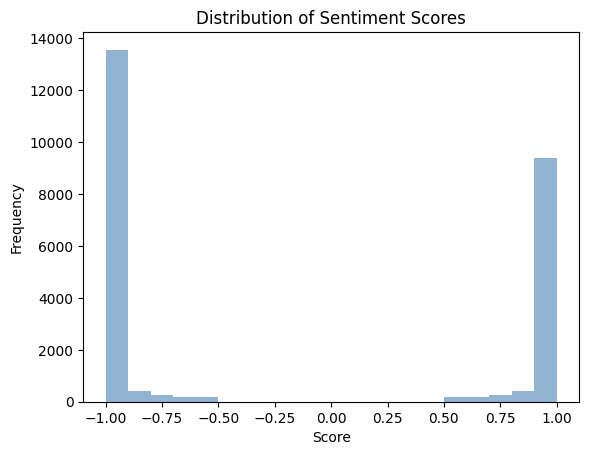

In [14]:
import matplotlib.pyplot as plt

plt.hist(test_df['score'], bins=20, alpha=0.6, color='steelblue')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


In [15]:
# TODO: Create target variable
# Convert binary labels to 5-star ratings using your features
# add points to score for other features
test_df['adjusted_score'] = (
    test_df['score']
    + 0.05 * np.log1p(test_df['word_count'])  # bonus for higher word count
    - 0.05 * (test_df['avg_word_length'] - test_df['avg_word_length'].mean())  # penalize for more elaborate words as it could indicate detachment
)

# now with score adjusted divide up into
test_df['star_rating'] = pd.cut(test_df['adjusted_score'], 5, labels=[1, 2, 3, 4, 5])
# Hint: Use sentiment scores and other features to estimate star rating

In [16]:
# checking how our data looks after adding stars
test_df['star_rating'].value_counts().sort_index()

,count
star_rating,
1,5428
2,9149
3,14
4,106
5,10303


In [18]:
# TODO: Build and train your model
# 1. Split data into train and test sets
from sklearn.model_selection import train_test_split
X = test_df[['word_count','avg_word_length', 'sentence_count',
            'avg_sentence_length','score']]
y = test_df['star_rating'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.02, random_state=42, stratify=y)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

# kept running into issues with the iterations timing out so ran a scaler on the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Choose a model suitable for multi-class classification
# starting with logistic regression and adjusting for multi-class since it's default is binary
from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import logistic regression
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1500,class_weight='balanced')
# 3. Train the model
log_reg.fit(X_train_scaled, y_train)
# 4. Make predictions
y_pred = log_reg.predict(X_test_scaled)
# 5. Evaluate performance
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n",classification_report(y_test, y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report:
               precision    recall  f1-score   support

           1       0.88      0.98      0.93       109
           2       0.99      0.90      0.94       183
           3       0.00      0.00      0.00         0
           4       0.22      1.00      0.36         2
           5       1.00      0.97      0.99       206

    accuracy                           0.95       500
   macro avg       0.62      0.77      0.64       500
weighted avg       0.97      0.95      0.95       500

Confusion Matrix:
 [[107   2   0   0   0]
 [ 15 165   2   1   0]
 [  0   0   0   0   0]
 [  0   0   0   2   0]
 [  0   0   0   6 200]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
from sklearn.ensemble import RandomForestClassifier
rfc_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)
rfc_model.fit(X_train, y_train)

y_pred_rf=rfc_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test,y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Classification Report:
               precision    recall  f1-score   support

           1       0.98      0.98      0.98       109
           2       0.99      0.99      0.99       183
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00       206

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500

Confusion Matrix:
 [[107   2   0   0]
 [  2 181   0   0]
 [  0   0   2   0]
 [  0   0   0 206]]


## Part 6: Analysis

Analyze your results and suggest improvements

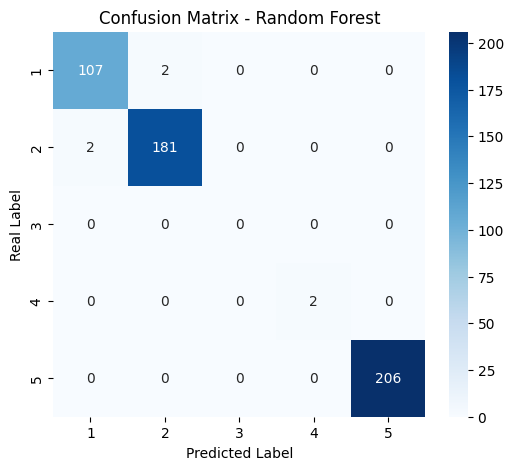

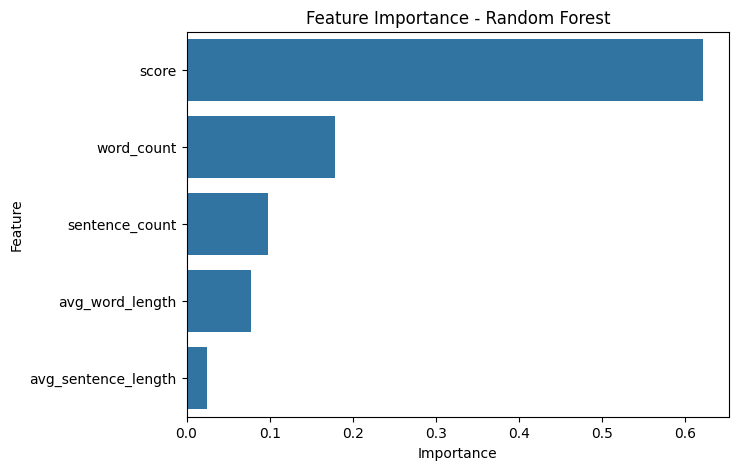

Total misclassified: 4


,word_count,avg_word_length,sentence_count,avg_sentence_length,score,true_rating,predicted_rating
1492,138,4.268116,6,23.00,-0.999702,1,2
578,140,4.378571,10,14.00,-0.992154,2,1
8517,154,4.525974,12,12.83,-0.988914,2,1
14102,190,5.415789,11,17.27,-0.964954,1,2


In [20]:
# TODO: Create visualizations and analyze:
# 1. Confusion matrix for multi-class predictions
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_rf, labels=[1,2,3,4,5])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues', xticklabels=[1,2,3,4,5], yticklabels =[1,2,3,4,5])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("Real Label")
plt.show()
# 2. Feature importance
feat_importance = pd.DataFrame({
    'Feature':X_train.columns,
    'Importance': rfc_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(7,5))
sns.barplot(x='Importance', y='Feature', data=feat_importance)
plt.title("Feature Importance - Random Forest")
plt.show()

feat_importance
# 3. Error analysis
# Create a smaller DataFrame that matches X_test size
eval_df = X_test.copy()
eval_df["true_rating"] = y_test
eval_df["predicted_rating"] = y_pred_rf

errors = eval_df[eval_df["true_rating"] != eval_df["predicted_rating"]]
print(f"Total misclassified: {len(errors)}")
errors.head(10)

# 4. Suggest improvements

'''
### Model Improvement Suggestions

1. Feature balance:
From the feature importance graphic, we see that the sentiment score dominates the model’s decision-making.
The model likely overlooks subtle distinctions between mildly emotional reviews (2–4 stars) and strongly emotional ones (1 & 5 stars), flattening the range of predictions.
An improvement could be, rather than removing the score feature, to experiment with adding more text-based features or rebalancing its influence through scaling or regularization.

2. Data balancing:
The confusion matrix shows that mid-range ratings (3 & 4 stars) have almost no representation because we divided the −1 to 1 sentiment range into five equal parts,
and the data distribution is heavily skewed toward the extremes.
An improvement could be switching from fixed-interval bins (`pd.cut`) to quantile-based bins (`pd.qcut`) when translating sentiment scores to star ratings.

3. Improving linguistic cues:
The error analysis and confusion matrix are looking good since the few errors occur between adjacent star categories (1 - 2) rather than across extremes (1 - 5).
This suggests the model captures sentiment direction but not its intensity.
An improvement could be, in addition to producing a single score, extracting richer sentiment features from the DistilBERT model — such as both positive and negative probabilities —
and adding engineered text cues like intensity words (“very,” “slightly,” “really”) or repeated punctuation (“!!!”) as features in the model.

'''

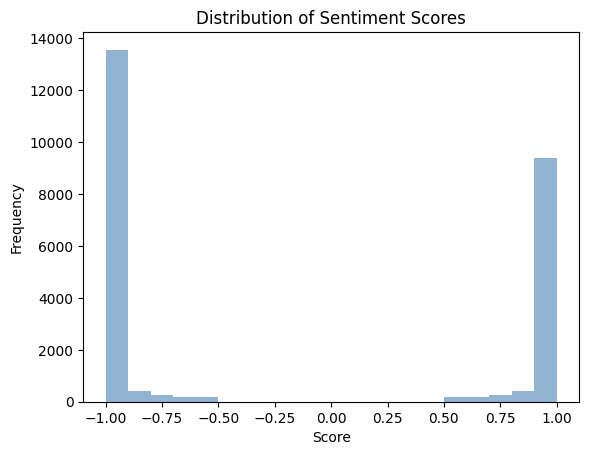

In [21]:
# data distribution from earlier to support improvement 2
plt.hist(test_df['score'], bins=20, alpha=0.6, color='steelblue')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()